In [1]:
from utils import *
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
def Nys_Sink(X, p, q, epsilon, eta, R):

    # Define epsilon prime
    n = X.shape[0]
    aux = (epsilon*eta)/(50*(4*(R**2)*eta + np.log(n/(epsilon*eta))))
    eps_prime = min(1, aux)

    # Compute Adaptive Nystrom
    tol = eps_prime/2 * np.exp(-4 * eta * R**2)
    V, L, r = AdaptiveNystrom(X, eps_prime, tol)

    print(f'Rank of the approximation: {r}')

    # Compute Sinkhorn

    D1, D2, W_hat = sinkhorn(V, L, p, q, eps_prime)

    # Round the solution
    P_hat = K_round(V, L, D1, D2, p, q)

    return P_hat, r

def Nys_Sink_rank(X, p, q, rank, eta, R, prec):
    '''
    Rank constrained Nys_Sink
    '''

    # Compute Nystrom approximation with fixed rank
    V, L, r = Nystrom_LS(X, rank, gauss, eta)

    # Compute Sinkhorn
    D1, D2, W_hat = sinkhorn(V, L, p, q, prec)

    # # return the rounded kernel matrix
    # invL = np.linalg.inv(L) # Complexity: O(r^3)
    # K_tilde = V @ invL.T @ invL @ V.T # Complexity: O(n r^2)

    # Round the solution
    P_hat = K_round(V, L, D1, D2, p, q)

    return P_hat, r

def Nys_Sink_rank_iter(X, p, q, rank, eta, R, N_iter):
    '''
    Rank constrained Nys_Sink
    '''

    # Compute Nystrom approximation with fixed rank
    V, L, r = Nystrom_LS(X, rank, gauss, eta)

    # Construct the cost matrix C_ij = ||x_i - x_j||^2
    X_norm = np.sum(X ** 2, axis=1).reshape(-1, 1)
    C = X_norm + X_norm.T - 2 * np.dot(X, X.T)

    # Compute Sinkhorn
    D1, D2, W_hat, Sink_cost = sinkhorn_iter(V, L, p, q, N_iter, eta, C)

    # check if D1 and D2 have negative values
    if np.any(D1 < 0) or np.any(D2 < 0):
        print('D1 or D2 have negative values')
        print('the minimum value of D1 is:', np.min(D1))
        print('the minimum value of D2 is:', np.min(D2))

    # # return the rounded kernel matrix
    # invL = np.linalg.inv(L) # Complexity: O(r^3)
    # K_tilde = V @ invL.T @ invL @ V.T # Complexity: O(n r^2)

    # Round the solution
    P_hat = K_round(V, L, D1, D2, p, q)
    P_hat_zero = np.where(P_hat < 1e-10, 1, P_hat)
    NS_Sink_cost = np.sum(np.multiply(P_hat, C)) + 1/eta * np.sum(np.multiply(P_hat_zero, np.log(P_hat_zero)))
  
    prova = compute_Sink_cost(V, L, D1, D2, p, q, eta, C)

    return P_hat, r, W_hat, Sink_cost



In [3]:
n = 200 # number of points
d = 2 # dimensionality

X = 0.8*np.random.rand(n, d)  # generate random data


R = np.max(np.linalg.norm(X, axis=1)) # compute the radius of the data

p = np.random.rand(n) # generate random weight
p[:int(n/2)] *= 2
p = p / np.sum(p)

q = np.random.rand(n) # generate random weights
q[int(n/2):] *= 2
q = q / np.sum(q)

# Construct the cost matrix C_ij = ||x_i - x_j||^2
X_norm = np.sum(X ** 2, axis=1).reshape(-1, 1)
C = X_norm + X_norm.T - 2 * np.dot(X, X.T)


In [4]:
eta = 5

# rnk_lst = [50, 75, 125, 200]
# rnk_lst = [50, 100, 300]
rnk_lst = [10, 15,20]
N_iter = 7
# n_cp = N_iter / (int(N_iter/5)) + 1
inter = int(N_iter/5)
n_cp = (N_iter - 1) // inter + 2
val_rnk = np.zeros((len(rnk_lst) + 1, int(n_cp)))

for i, r in enumerate(rnk_lst):

  # P_hat, rnk = Nys_Sink_rank(X, p, q, r, eta, R, 2e-05) # compute the optimal transport plan
  P_hat, rnk, W_hat, Sink_cost = Nys_Sink_rank_iter(X, p, q, r, eta, R, N_iter) # compute the optimal transport plan


  # evaluate the regularized cost

  P_hat_zero = np.where(P_hat < 1e-10, 1, P_hat)
  NS_Sink_cost = np.sum(np.multiply(P_hat, C)) + 1/eta * np.sum(np.multiply(P_hat_zero, np.log(P_hat_zero)))

  Sink_cost.append(NS_Sink_cost)
  val_rnk[i, :] = Sink_cost

  print(f'NS_regularized_cost last for rank {r} is {Sink_cost[-1]} while the estimated one is {W_hat}')

  # if Sink_cost[-1] - NS_Sink_cost > 1e-3:
  #   print(f'The difference between the two costs is {Sink_cost[-1] - NS_Sink_cost}')

  # # compute the excess risk wrt to ot_cost
  # NS_cost = np.sum(np.multiply(P_hat, C))
  # print(f'NS_cost for rank {r} is {NS_cost}')
  # exr_lst.append(np.abs(ot_cost - NS_cost ))
  # exr_lst.append(np.abs(ot_value - NS_Sink_cost))

# P_hat, rnk = Nys_Sink(X, p, q, 10, eta, R) # compute the optimal transport plan

Iteration 1 with deviation 0.5793398376945749 with cost -1.9041339070913048
Iteration 2 with deviation 0.020202791520933724 with cost -1.8722986431786064
Iteration 3 with deviation 0.004772388449483912 with cost -1.855909806234411
Iteration 4 with deviation 0.0019120783904052316 with cost -1.8574751086735464
Iteration 5 with deviation 0.0008087237847198707 with cost -1.8558971422956132
Iteration 6 with deviation 0.00035316605403037525 with cost -1.8561935141139125
Final deviation 0.00035316605403037525 and estimated cost -9.122582082355319
NS_regularized_cost last for rank 10 is -1.855901807552709 while the estimated one is -9.122582082355319
Iteration 1 with deviation 0.5741990916593025 with cost -1.9051736503505856
Iteration 2 with deviation 0.023304498668109356 with cost -1.8757550805669547
Iteration 3 with deviation 0.007041516833515857 with cost -1.8568806074655275
Iteration 4 with deviation 0.003051337574274726 with cost -1.859354352062854
Iteration 5 with deviation 0.00136031096

In [7]:
# epsilon = 0.01 # precision parameter

# Regularization parameter
gamma = 1/eta


# Variables
P_c = cp.Variable((n,n), nonneg=True)

# Objective: Minimize the cost with KL divergence regularization
objective = cp.Minimize(cp.sum(cp.multiply(C, P_c)) - gamma * cp.sum(cp.entr(P_c)))
# objective = cp.Minimize(cp.sum(cp.multiply(C, P_c)))


# Constraints: Marginals must match p and q
constraints = [
    cp.sum(P_c, axis=1) == p,
    cp.sum(P_c, axis=0) == q
]

# Problem
problem = cp.Problem(objective, constraints)

# Solve
problem.solve()

# Optimal transport plan
P_opt = P_c.value

In [9]:
# Sinkhorn with the full kernel

D1, D2, S_cost = Classic_Sinkhorn(eta, C, p, q, N_iter)
val_rnk[-1] = S_cost

Iteration 1 with deviation 0.02027958072299874 with cost -1.8568861527249039
Iteration 2 with deviation 0.004332326492892339 with cost -1.8571915750632901
Iteration 3 with deviation 0.0009386526174129683 with cost -1.8571245834346104
Iteration 4 with deviation 0.00020499541231283584 with cost -1.8571089615858294
Iteration 5 with deviation 4.503350438694979e-05 with cost -1.8571055168875055
Iteration 6 with deviation 9.944834812974398e-06 with cost -1.8571047586867944


In [10]:
# 5 iter
# ot_cost = np.sum(np.multiply(P_opt, C))
ot_value = problem.value
print(f'Optimal Sinkhorn cost is {ot_value}')

exr_lst = np.abs(ot_value - val_rnk)
print(f'Excess risk list is {exr_lst}')

print(f'S_cost is {S_cost}')

Optimal Sinkhorn cost is -1.8571045441017442
Excess risk list is [[6.24840668e+01 4.51456256e-02 1.83760816e-02 5.94980205e-04
  2.67156875e-03 6.47390821e-04 7.82004866e-06 6.56569326e-04]
 [7.17795976e-01 4.54177752e-02 1.75911509e-02 5.90383998e-05
  3.18148146e-03 2.11653138e-06 6.81277332e-04 7.76147975e-06]
 [1.08453434e+00 4.54082655e-02 1.76968407e-02 7.12702436e-05
  3.23393942e-03 1.24881481e-05 7.02104157e-04 2.33289761e-06]
 [1.85710454e+00 2.18391377e-04 8.70309615e-05 2.00393329e-05
  4.41748409e-06 9.72785761e-07 2.14585050e-07 4.73403454e-08]]
S_cost is [0.0, -1.8568861527249039, -1.8571915750632901, -1.8571245834346104, -1.8571089615858294, -1.8571055168875055, -1.8571047586867944, -1.8571045914420896]


In [11]:
# 20 iter
# ot_cost = np.sum(np.multiply(P_opt, C))
ot_value = problem.value
print(f'Optimal Sinkhorn cost is {ot_value}')

exr_lst = np.abs(ot_value - val_rnk)
print(f'Excess risk list is {exr_lst}')

Optimal Sinkhorn cost is -1.8571045441017442
Excess risk list is [[6.24840668e+01 4.51456256e-02 1.83760816e-02 5.94980205e-04
  2.67156875e-03 6.47390821e-04 7.82004866e-06 6.56569326e-04]
 [7.17795976e-01 4.54177752e-02 1.75911509e-02 5.90383998e-05
  3.18148146e-03 2.11653138e-06 6.81277332e-04 7.76147975e-06]
 [1.08453434e+00 4.54082655e-02 1.76968407e-02 7.12702436e-05
  3.23393942e-03 1.24881481e-05 7.02104157e-04 2.33289761e-06]
 [1.85710454e+00 2.18391377e-04 8.70309615e-05 2.00393329e-05
  4.41748409e-06 9.72785761e-07 2.14585050e-07 4.73403454e-08]]


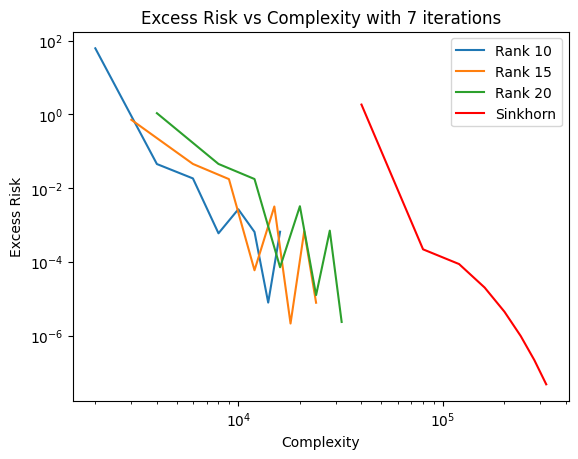

In [41]:
# Plot 

plt.figure()

complexity = n * rnk_lst

if N_iter // 5 == 0:
    iterations = np.arange(0, N_iter+1, int(N_iter/5))

max_iter_inf = np.floor(N_iter/inter) * inter
if N_iter % inter == 0:
    iterations = np.arange(0, N_iter+1, inter)
    
else:
    iterations = np.arange(0, max_iter_inf+1, inter)
    iterations = np.append(iterations, N_iter)

for i, r in enumerate(rnk_lst):

    flops = n*r*iterations
    flops += n*(r**2) # add the cost of the initialization
    plt.plot(flops, exr_lst[i], label=f'Rank {r}')

flops_sink = n**2*iterations
flops_sink += n**2 # add the cost of the initialization
plt.plot(flops_sink, exr_lst[-1], label='Sinkhorn', color='red')

plt.xlabel('Complexity')
plt.ylabel('Excess Risk')
plt.yscale('log')
plt.xscale('log')
# plt.xlim(-1, n**2*N_iter + 1)
plt.title(f'Excess Risk vs Complexity with {N_iter} iterations')
plt.legend()
plt.show()

[[1.17354347e-04 6.37438011e-06 6.49595228e-05 ... 2.15280343e-05
  2.33147832e-04 4.12585328e-05]
 [1.16227524e-05 1.24595696e-05 4.32416958e-05 ... 3.35894655e-05
  2.59214037e-05 3.29222473e-05]
 [2.43216195e-05 8.87935436e-06 8.42040621e-05 ... 4.37821082e-05
  1.08498644e-04 4.70034977e-05]
 ...
 [4.46193018e-07 3.81812950e-07 2.42361945e-06 ... 1.63036730e-06
  1.83955770e-06 1.47887537e-06]
 [1.71925184e-05 1.04832504e-06 2.13689312e-05 ... 6.54490880e-06
  8.24556793e-05 1.02053297e-05]
 [1.49950377e-05 6.56224266e-06 4.56261929e-05 ... 2.59326748e-05
  5.02982177e-05 2.83837307e-05]]


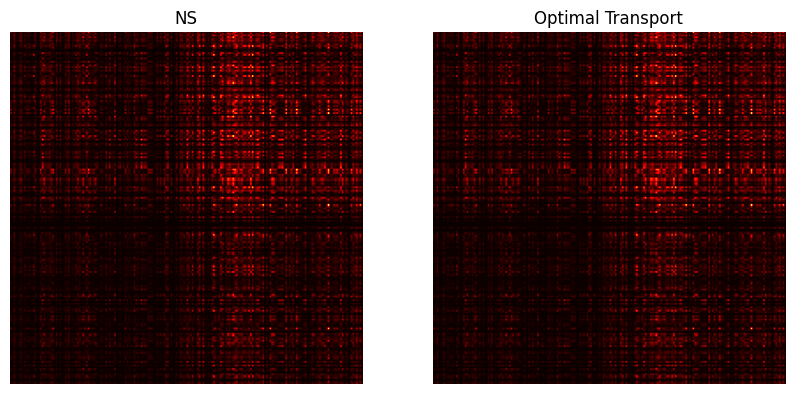

In [13]:

# print(P_hat)
print(P_opt)

# compare P and P_opt
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(P_hat , cmap="hot")
plt.title("NS")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(P_opt + 1, cmap="hot")
plt.title("Optimal Transport")
plt.axis("off")

plt.show()